# **Battle of the Nieghboorhoods (Week 2)**

## **1. Introduction to the Business Problem**

An eager new chef is looking to establish himself in the Los Angeles culinary scene, but he is not sure which location will be the most successful. Los Angeles has numerous locations with a robust restaurant scene, but data analysis is necessary to chose the correct location. Ensuring the right location could be make it or break it for this this chef and several factors will be considered in the location hunt. According to [The Balance Small Business website](https://www.thebalancesmb.com/choosing-restaurant-location-2888543), there are several pertinent decision making factors. 

1. Visibility - Setting up in  a high foot traffic area. 
2. Size - How big or small is the restaurant going to be. 
3. Neighborhood - This is two pronged, in that who else has a restaurant space as well as the crime statistics in the area. 
4. Affordability - The cost of the lot. 
5. Competitor Analysis - This goes hand in hand with Neighborhood but is important in it's own right. 

In this project, we will use data from the Foursqaure API to address the aforementioned data points. 

## **2. Data**

We will attempt to address all the factors above, but will likely be limited to lack of availability of some data sets. The most important factors, and the ones we will work with will be _Visibility_, and _Crime Rates_. Competitor analysis will be inherent within the project. 

##### Datasets:

1. Los Angeles Crime data from 2020 to Present - This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. [Link](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8)
2. Los Angeles Neighborhoods - Official Certified Neighborhood Council boundaries in the City of Los Angeles created and maintained by the Bureau of Engineering / GIS Mapping Division. [Link](https://data.lacity.org/A-Well-Run-City/Neighborhoods/ykhe-zspy)
3. Building Permits by Neighborhood - [Link](https://data.lacity.org/A-Prosperous-City/Building-Permits-by-Neighborhood-Council/8dmw-8ykh)

#### Search Engines:

[Foursqaure](https://foursquare.com/). We will use the foursquare API to carry out venue and point of interest search. The results will give us an idea of the neighborhood of the venue's potential location.

# **3. Methodology**

 For this project, we will explore Los Angeles Neighborhood and Crime data with the intent to answer the critical factors discussed in the intro. Following that, utilization of the Foursquare API will allow us to explore data within our neighborhoods, providing information on venues and other types of restaurants. The neighborhoods will be clustered using the $k$-mean algorithm. The culminating results will provide potential restaurant locations for our entrepreneurial chef.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pysal as ps
import requests
import os
import ogr

from pandas.io.json import json_normalize
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
from sklearn.cluster import KMeans
#from branca.utilities import split_six

%matplotlib inline

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


## **3.1 Los Angeles Crime Data Analysis**

 Read the Los Angeles Police Department crime reports and perform our initial checks. 

In [2]:
df_crime = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61164 entries, 0 to 61163
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DR_NO           61164 non-null  int64  
 1   Date Rptd       61164 non-null  object 
 2   DATE OCC        61164 non-null  object 
 3   TIME OCC        61164 non-null  int64  
 4   AREA            61164 non-null  int64  
 5   AREA NAME       61164 non-null  object 
 6   Rpt Dist No     61164 non-null  int64  
 7   Part 1-2        61164 non-null  int64  
 8   Crm Cd          61164 non-null  int64  
 9   Crm Cd Desc     61164 non-null  object 
 10  Mocodes         53863 non-null  object 
 11  Vict Age        61164 non-null  int64  
 12  Vict Sex        54239 non-null  object 
 13  Vict Descent    54238 non-null  object 
 14  Premis Cd       61163 non-null  float64
 15  Premis Desc     61137 non-null  object 
 16  Weapon Used Cd  22337 non-null  float64
 17  Weapon Desc     22337 non-null 

First five rows of dataset

In [3]:
pd.set_option('display.max_columns', 180)
df_crime.head()

DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0   10304468  01/08/2020 12:00:00 AM  01/08/2020 12:00:00 AM      2230     3   
1  190101086  01/02/2020 12:00:00 AM  01/01/2020 12:00:00 AM       330     1   
2  190101087  01/02/2020 12:00:00 AM  01/01/2020 12:00:00 AM       510     1   
3  191501505  01/01/2020 12:00:00 AM  01/01/2020 12:00:00 AM      1730    15   
4  191921269  01/01/2020 12:00:00 AM  01/01/2020 12:00:00 AM       415    19   

     AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0    Southwest          377         2     624   
1      Central          163         2     624   
2      Central          156         2     626   
3  N Hollywood         1543         2     745   
4      Mission         1998         2     740   

                                         Crm Cd Desc  \
0                           BATTERY - SIMPLE ASSAULT   
1                           BATTERY - SIMPLE ASSAULT   
2                  INTIMATE PARTNER - SIMPLE ASSAULT   
3           VANDALISM - MISDEAMEANOR ($399 OR UNDER)   
4  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...   

                         Mocodes  Vict Age Vict Sex Vict Descent  Premis Cd  \
0                      0444 0913        36        F            B      501.0   
1                 0416 1822 1414        25        M            H      102.0   
2  1414 1218 2000 1814 0416 0447        53        F            B      502.0   
3                      0329 1402        76        F            W      502.0   
4                           0329        31        X            X      409.0   

                                    Premis Desc  Weapon Used Cd  \
0                        SINGLE FAMILY DWELLING           400.0   
1                                      SIDEWALK           500.0   
2  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)           400.0   
3  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)             NaN   
4                           BEAUTY SUPPLY STORE             NaN   

                                      Weapon Desc Status  Status Desc  \
0  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     AO  Adult Other   
1                     UNKNOWN WEAPON/OTHER WEAPON     IC  Invest Cont   
2  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     IC  Invest Cont   
3                                             NaN     IC  Invest Cont   
4                                             NaN     IC  Invest Cont   

   Crm Cd 1  Crm Cd 2  Crm Cd 3  Crm Cd 4  \
0       624       NaN       NaN       NaN   
1       624       NaN       NaN       NaN   
2       626       NaN       NaN       NaN   
3       745     998.0       NaN       NaN   
4       740       NaN       NaN       NaN   

                                   LOCATION Cross Street      LAT       LON  
0   1100 W  39TH                         PL          NaN  34.0141 -118.2978  
1    700 S  HILL                         ST          NaN  34.0459 -118.2545  
2    300 E  5TH                          ST          NaN  34.0449 -118.2458  
3   5400    CORTEEN                      PL          NaN  34.1685 -118.4019  
4  14400    TITUS                        ST          NaN  34.2198 -118.4468

To get the most impactful information from our data, we remove unnecessary columns, and keep Crime Description, Locational Data, and Time Stamps.

In [4]:
columns = ['DR_NO', 'Date Rptd', 'TIME OCC', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 
           'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 
           'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2',
           'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street']
df_crime = df_crime.drop(columns, axis=1)

Dropping the NaN Rows from rest of dataset.

In [5]:
df_crime.isnull().sum()

DATE OCC       0
AREA           0
AREA NAME      0
Crm Cd Desc    0
LAT            0
LON            0
dtype: int64

No we need the type of incidents reported. 

In [6]:
df_crime.dropna(inplace=True)
df_crime.isnull().sum()

DATE OCC       0
AREA           0
AREA NAME      0
Crm Cd Desc    0
LAT            0
LON            0
dtype: int64

In [7]:
df_crime['Crm Cd Desc'].unique()

array(['BATTERY - SIMPLE ASSAULT', 'INTIMATE PARTNER - SIMPLE ASSAULT',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'RAPE, FORCIBLE', 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'OTHER MISCELLANEOUS CRIME',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BURGLARY FROM VEHICLE', 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
       'ARSON', 'VEHICLE - STOLEN', 'THEFT PLAIN - PETTY ($950 & UNDER)',
       'ROBBERY', 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'BRANDISH WEAPON', 'BURGLARY',
       'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 'BIKE - STOLEN',
       'FIREARMS RESTRAINING ORDER (FIREARMS RO)',
       'VIOLATION OF COURT ORDER', 'THEFT, PERSON', 'CRIMINAL HOMICIDE',
       'BATTERY WITH SEXUAL CONTACT', 'BATTERY POLICE (SIMPLE)',
       'THEFT OF IDENTITY', 'TRESPASSING',
       'INTIMATE PARTNER - A

There are some crimes that do warrant inclusion into our analysis, but that is subjective, so we will retain all categories of reported crime incidents. 

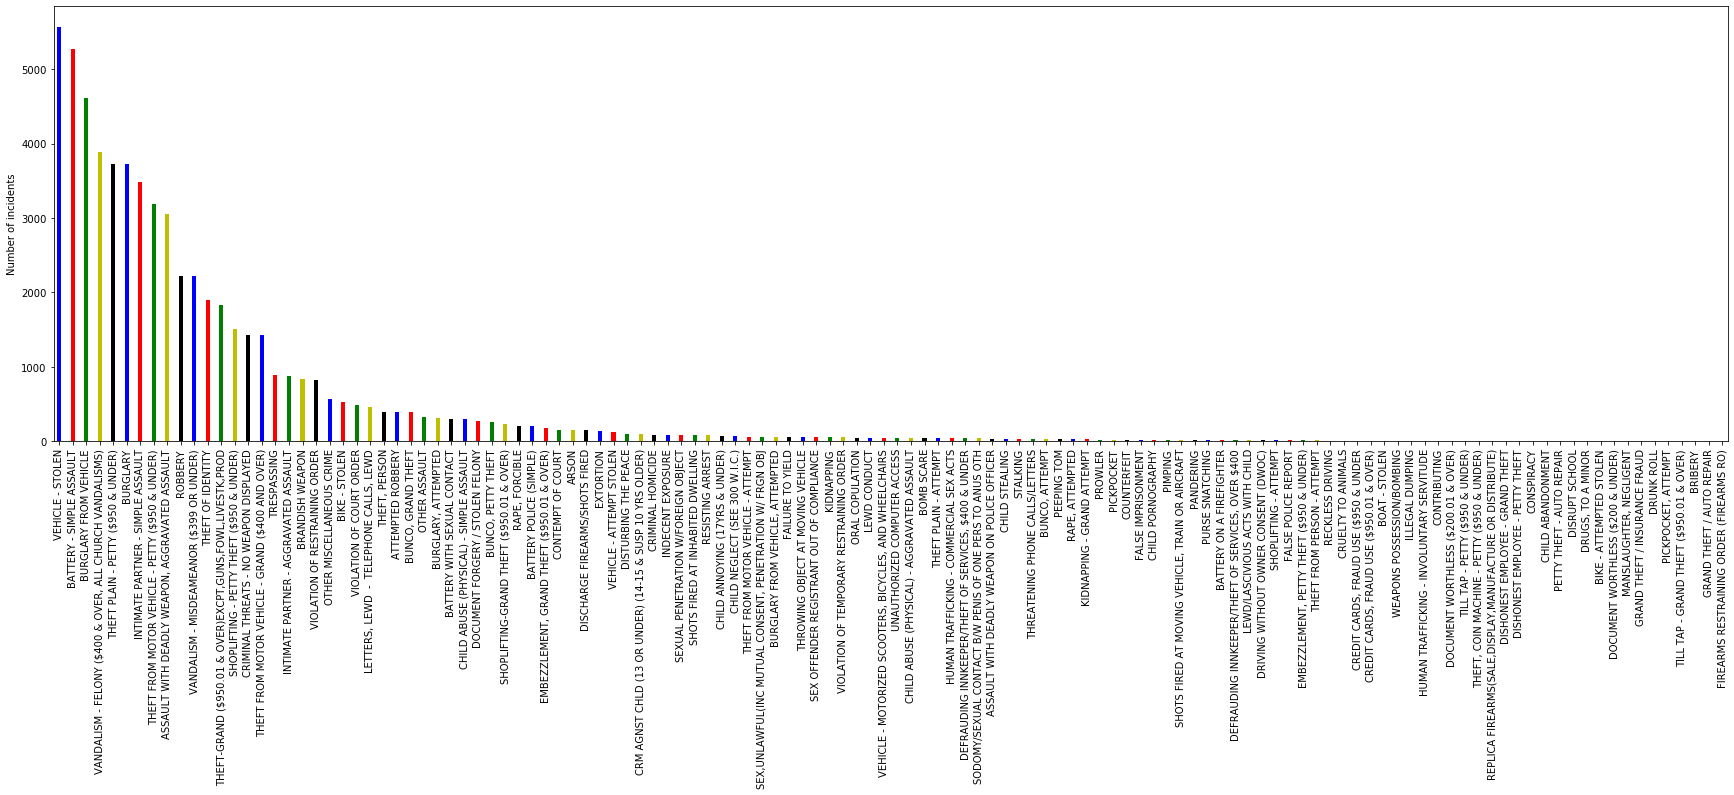

In [8]:
my_colors = list(['b', 'r', 'g', 'y', 'k'])
df_crime['Crm Cd Desc'].value_counts().plot(kind='bar', figsize=(30,8), color=my_colors, align='center', width=0.3)
plt.ylabel('Number of incidents')
plt.show()

The highest reported crime is  _Vehicle-Stolen_, _Battery-Simple Assault_, followed by _Burglary From Vehicle_.

Let's visualize reported crime by specific _Area_. 

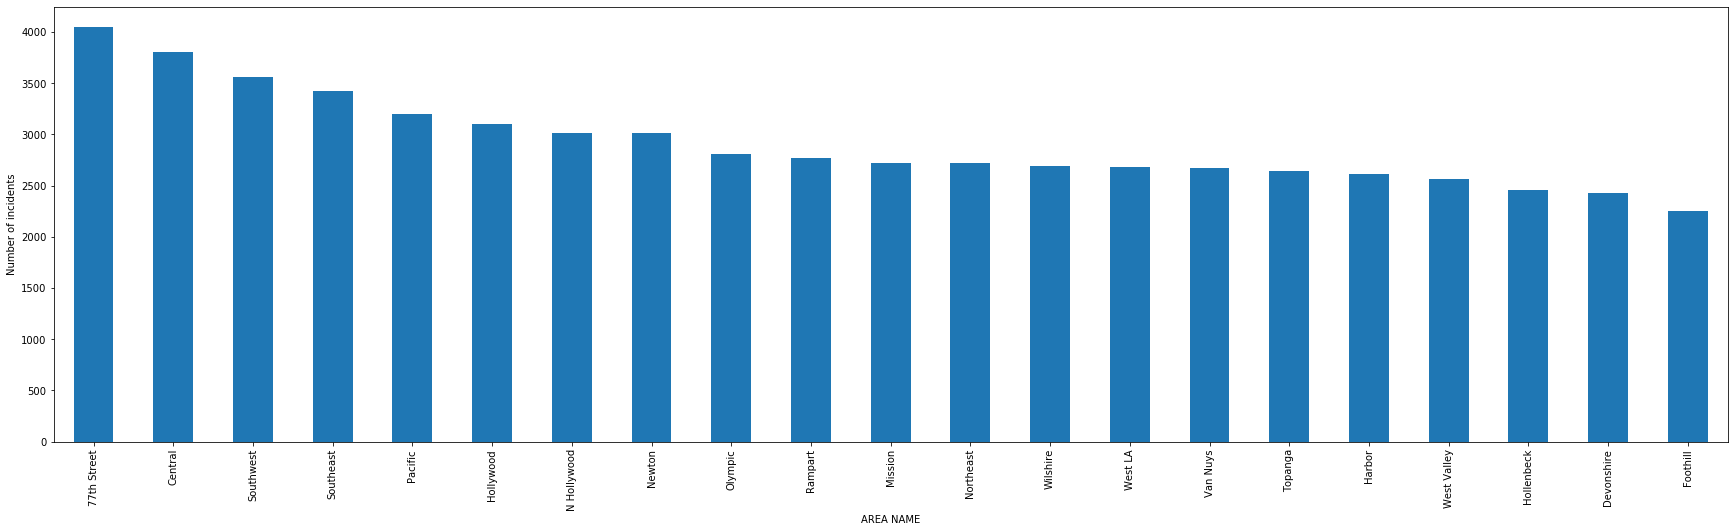

In [9]:
# calculating total number of incidents per area
crimedata_area = pd.DataFrame(df_crime['AREA NAME'].value_counts().astype(float))
crimedata_area = crimedata_area.reset_index()
crimedata_area.columns = ['AREA NAME', 'Number']
crimedata_area.plot(kind='bar', figsize=(30,8), legend=None)
xticks = [i for i in range(len(crimedata_area))]
plt.xticks(xticks, list(crimedata_area['AREA NAME']))
plt.xlabel('AREA NAME')
plt.ylabel('Number of incidents')
plt.show()

Crime is prevalent across most the areas in lA, with the _77th Street Area_ having the highest reported data followed by _Central_

### **Process the crime data for mapping**

Create a Shapely object for our crime data. 

Convert data into GeoDataFrame

In [10]:
crime = gpd.read_file('crime.shp')
crime.head()

DR_NO               Date_Rptd                DATE_OCC  TIME_OCC  AREA  \
0   10304468  01/08/2020 12:00:00 AM  01/08/2020 12:00:00 AM      2230     3   
1  190101086  01/02/2020 12:00:00 AM  01/01/2020 12:00:00 AM       330     1   
2  190101087  01/02/2020 12:00:00 AM  01/01/2020 12:00:00 AM       510     1   
3  191501505  01/01/2020 12:00:00 AM  01/01/2020 12:00:00 AM      1730    15   
4  191921269  01/01/2020 12:00:00 AM  01/01/2020 12:00:00 AM       415    19   

     AREA_NAME  Rpt_Dist_N  Part_1_2  Crm_Cd  \
0    Southwest         377         2     624   
1      Central         163         2     624   
2      Central         156         2     626   
3  N Hollywood        1543         2     745   
4      Mission        1998         2     740   

                                          Crm_Cd_Des  \
0                           BATTERY - SIMPLE ASSAULT   
1                           BATTERY - SIMPLE ASSAULT   
2                  INTIMATE PARTNER - SIMPLE ASSAULT   
3           VANDALISM - MISDEAMEANOR ($399 OR UNDER)   
4  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...   

                         Mocodes  Vict_Age Vict_Sex Vict_Desce  Premis_Cd  \
0                      0444 0913        36        F          B        501   
1                 0416 1822 1414        25        M          H        102   
2  1414 1218 2000 1814 0416 0447        53        F          B        502   
3                      0329 1402        76        F          W        502   
4                           0329        31        X          X        409   

                                     Premis_Des  Weapon_Use  \
0                        SINGLE FAMILY DWELLING         400   
1                                      SIDEWALK         500   
2  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)         400   
3  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)           0   
4                           BEAUTY SUPPLY STORE           0   

                                       Weapon_Des Status   Status_Des  \
0  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     AO  Adult Other   
1                     UNKNOWN WEAPON/OTHER WEAPON     IC  Invest Cont   
2  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     IC  Invest Cont   
3                                            None     IC  Invest Cont   
4                                            None     IC  Invest Cont   

   Crm_Cd_1  Crm_Cd_2 Crm_Cd_3 Crm_Cd_4  \
0       624         0     None     None   
1       624         0     None     None   
2       626         0     None     None   
3       745       998     None     None   
4       740         0     None     None   

                                   LOCATION Cross_Stre      LAT       LON  \
0   1100 W  39TH                         PL       None  34.0141 -118.2978   
1    700 S  HILL                         ST       None  34.0459 -118.2545   
2    300 E  5TH                          ST       None  34.0449 -118.2458   
3   5400    CORTEEN                      PL       None  34.1685 -118.4019   
4  14400    TITUS                        ST       None  34.2198 -118.4468   

                      geometry  
0  POINT (-118.29780 34.01410)  
1  POINT (-118.25450 34.04590)  
2  POINT (-118.24580 34.04490)  
3  POINT (-118.40190 34.16850)  
4  POINT (-118.44680 34.21980)

In [11]:
print(crime.crs)

epsg:4326


## **3.2 Los Angeles Neighborhoods**

To map out the crime data, we will work with neighborhoods,  which is created by the Official Certified Neighborhood Council boundaries in the City of Los Angeles created and maintained by the Bureau of Engineering / GIS Mapping Division. We download the shape file from the website and import it using GeoPandas.

In [12]:
nbrhoods = gpd.read_file('la_neighborhoods.shp')
nbrhoods.head()

date_certi    time_certi                              dwebsite  \
0  2002-04-27  00:00:00.000             http://empowerla.org/LHNC   
1  2008-06-16  00:00:00.000  https://empowerla.org/voicesof90037/   
2  2002-06-11  00:00:00.000             http://empowerla.org/LFNC   
3  2005-04-19  00:00:00.000             http://empowerla.org/MHNC   
4  2002-09-10  00:00:00.000            http://empowerla.org/GTLNC   

                     name  nc_id  objectid                    service_re  \
0      LINCOLN HEIGHTS NC   47.0       1.0      REGION 8 - NORTH EAST LA   
1         VOICES OF 90037  109.0       2.0         REGION 9 - SOUTH LA 2   
2            LOS FELIZ NC   36.0       3.0               REGION 7 - EAST   
3        MISSION HILLS NC  101.0       4.0  REGION 1 - NORTH EAST VALLEY   
4  GREATER TOLUCA LAKE NC   28.0       5.0  REGION 4 - SOUTH EAST VALLEY   

                           waddress  \
0  http://www.lincolnheightsnc.org/   
1          https://www.voicesnc.org   
2        http://www.losfeliznc.org/   
3            http://mhnconline.org/   
4             http://www.gtlnc.org/   

                                            geometry  
0  POLYGON ((-118.20503 34.05558, -118.20605 34.0...  
1  POLYGON ((-118.28273 34.01114, -118.28234 34.0...  
2  POLYGON ((-118.30027 34.15793, -118.29883 34.1...  
3  POLYGON ((-118.46933 34.28050, -118.46931 34.2...  
4  POLYGON ((-118.35520 34.16491, -118.35529 34.1...

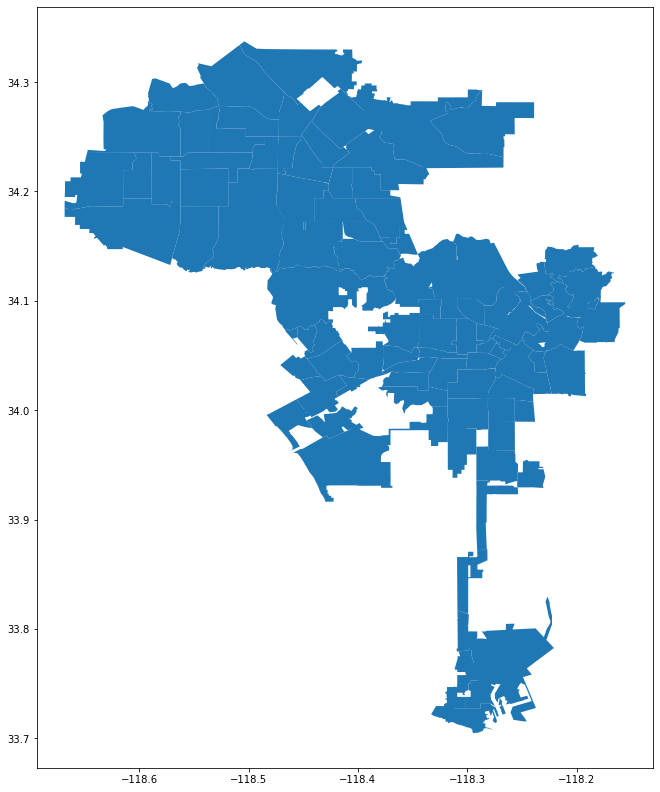

In [13]:
nbrhoods.plot(figsize=(12,14))
plt.show()

Check the reference for _nbrhoods'_

In [14]:
print(nbrhoods.crs)

epsg:4326


### Neighborhood specific crime numbers need to be aggregated. 

This is calculated through a sjoin GeoPandas function. 

In [15]:
nbh_crime_counts = gpd.tools.sjoin(crime.to_crs(nbrhoods.crs), nbrhoods, how="inner", op='intersects').groupby('name').size()
nbh_crime_counts = pd.DataFrame(data=nbh_crime_counts.reset_index())
nbh_crime_counts.columns=['name', 'incident_counts']
nbh_crime_counts.head()

name  incident_counts
0                 ARLETA NC              288
1            ARROYO SECO NC              196
2        ATWATER VILLAGE NC              141
3  BEL AIR-BEVERLY CREST NC              222
4          BOYLE HEIGHTS NC             1295

In [16]:
nbrhoods = nbrhoods.merge(nbh_crime_counts, on='name')
nbrhoods.head()

date_certi    time_certi                              dwebsite  \
0  2002-04-27  00:00:00.000             http://empowerla.org/LHNC   
1  2008-06-16  00:00:00.000  https://empowerla.org/voicesof90037/   
2  2002-06-11  00:00:00.000             http://empowerla.org/LFNC   
3  2005-04-19  00:00:00.000             http://empowerla.org/MHNC   
4  2002-09-10  00:00:00.000            http://empowerla.org/GTLNC   

                     name  nc_id  objectid                    service_re  \
0      LINCOLN HEIGHTS NC   47.0       1.0      REGION 8 - NORTH EAST LA   
1         VOICES OF 90037  109.0       2.0         REGION 9 - SOUTH LA 2   
2            LOS FELIZ NC   36.0       3.0               REGION 7 - EAST   
3        MISSION HILLS NC  101.0       4.0  REGION 1 - NORTH EAST VALLEY   
4  GREATER TOLUCA LAKE NC   28.0       5.0  REGION 4 - SOUTH EAST VALLEY   

                           waddress  \
0  http://www.lincolnheightsnc.org/   
1          https://www.voicesnc.org   
2        http://www.losfeliznc.org/   
3            http://mhnconline.org/   
4             http://www.gtlnc.org/   

                                            geometry  incident_counts  
0  POLYGON ((-118.20503 34.05558, -118.20605 34.0...              455  
1  POLYGON ((-118.28273 34.01114, -118.28234 34.0...             1053  
2  POLYGON ((-118.30027 34.15793, -118.29883 34.1...              548  
3  POLYGON ((-118.46933 34.28050, -118.46931 34.2...              262  
4  POLYGON ((-118.35520 34.16491, -118.35529 34.1...              161

### **3.3 Generating Crime Maps**

In [47]:
#nbh_centroid = pd.DataFrame(nbrhoods.centroid)
nbh_centroid = pd.DataFrame(nbrhoods.representative_point())
nbh_centroid.columns=(['centroid'])
nbh_centroid['name'] = nbrhoods['name']
nbh_centroid['incident_counts'] = nbrhoods['incident_counts']

lat = []
lng = []
for index, row in nbh_centroid.iterrows():
    tmp = str(row[0]).strip('POINT ()').split(' ')
    lng.append(float(tmp[0]))
    lat.append(float(tmp[1]))
    #print(tmp[0], tmp[1])
    
nbh_centroid['Latitude'] = lat
nbh_centroid['Longitude'] = lng

nbh_centroid = nbh_centroid.drop(columns=['centroid'])

nbh_centroid.head(30)

name  incident_counts  \
0                                  LINCOLN HEIGHTS NC              455   
1                                     VOICES OF 90037             1053   
2                                        LOS FELIZ NC              548   
3                                    MISSION HILLS NC              262   
4                              GREATER TOLUCA LAKE NC              161   
5                                    SOUTH CENTRAL NC              832   
6                                  SUNLAND-TUJUNGA NC              395   
7                                       PICO UNION NC              666   
8                         FOOTHILL TRAILS DISTRICT NC              238   
9                                          TARZANA NC              515   
10                                         PACOIMA NC              824   
11                                      WEST ADAMS NC              475   
12                                          RESEDA NC              856   
13                       NORTH HOLLYWOOD NORTHEAST NC              499   
14                                            NOHO NC             1096   
15                                      WILMINGTON NC              862   
16                               NC WESTCHESTER/PLAYA             1124   
17                                     ZAPATA KING NC              855   
18                                        VAN NUYS NC             1374   
19  UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...              729   
20            EMPOWERMENT CONGRESS SOUTHWEST AREA NDC              583   
21                                        P.I.C.O. NC              324   
22                               HISTORIC CULTURAL NC              340   
23                                        WESTWOOD NC              217   
24                                 SUN VALLEY AREA NC              705   
25                        ELYSIAN VALLEY RIVERSIDE NC               73   
26                             NORTHWEST SAN PEDRO NC              203   
27                                  WESTLAKE NORTH NC              368   
28                                   MID CITY WEST CC             1205   
29                         HISTORIC CULTURAL NORTH NC              594   

     Latitude   Longitude  
0   34.072527 -118.209900  
1   33.996490 -118.290347  
2   34.128590 -118.296138  
3   34.270806 -118.455143  
4   34.154982 -118.357589  
5   34.020202 -118.259703  
6   34.261650 -118.294147  
7   34.044766 -118.285788  
8   34.256381 -118.356438  
9   34.155869 -118.546768  
10  34.266295 -118.406749  
11  34.026870 -118.356030  
12  34.203790 -118.540422  
13  34.208262 -118.392139  
14  34.173115 -118.374136  
15  33.772590 -118.264432  
16  33.952296 -118.409757  
17  34.000335 -118.268684  
18  34.190695 -118.457117  
19  34.032893 -118.321941  
20  33.956845 -118.308998  
21  34.048197 -118.360328  
22  34.044527 -118.235128  
23  34.064742 -118.427303  
24  34.228737 -118.386063  
25  34.094914 -118.240396  
26  33.754579 -118.299002  
27  34.061159 -118.264364  
28  34.071624 -118.363927  
29  34.066224 -118.237270

define a function for popups

In [18]:
def get_popups(df, field, name, map_object):
    for lat, lng, nbrhood, value in zip( df['Latitude'], 
                                         df['Longitude'], 
                                         df['name'], 
                                         df[field]
                                       ):
        label = ("{0}, {1}: {2:.2f}").format(nbrhood, name, value)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color='green',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3).add_to(map_object)

LA Coordinates

In [19]:
LA_Coord = (34.0522, -118.2437)

 Creating Crime Map

In [20]:
# Create LA base map
LA_crime_map = folium.Map(location=LA_Coord, zoom_start=12)

#geodata = gpd.read_file('./tmp/
# Crime data at the census tract level
threshold_scale = [0, 1000, 2000, 4000, 6000, 8000]
LA_crime_map.choropleth(geo_data        = nbrhoods.to_json(),
                        data            = nbrhoods,
                        columns         = ['name', 'incident_counts'], 
                        key_on          = 'feature.properties.name',
                        fill_color      = 'YlOrRd', 
                        fill_opacity    = 0.60, 
                        line_opacity    = 0.60,
                        legend_name     = 'Number of incidents',
                        name            = 'Number of Incidents',
                        threshold_scale = threshold_scale,
                                  reset = True                             
                       )

get_popups(nbh_centroid, 'incident_counts', 'Incident Counts', LA_crime_map)

# Add control layer to the map
#folium.LayerControl().add_to(LA_crime_map)
#LA_crime_map

In [21]:
display(LA_crime_map)

### **3.4 Exploring and Clustering Venues in Los Angeles**

In this section, are going to use the Foursquare APIs to explore LA neighborhoods and cluster them using k-means clustering.

Set up Foursqure API id and basic API call parameters.

In [22]:
# @hidden_cell
CLIENT_ID = 'TDKYEETQOR1PQILI2I00DKPNZENOZXICXFKVQXD0CQRIUQ4J'     
CLIENT_SECRET = 'DROVWJGZRBEXQGMOQOLVATHFWNDJKB44DPCDU2WW00CGP21U' 
VERSION = '20200505'

# Set up the FourSquare API call parameters
RADIUS = 500
LIMIT  = 100

Defining venue extraction function.

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**From the Foursquare API, we receive venue recommendations.**

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_check_list = []
    venues_list=[]
    idx = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        num_of_venues_found = len(results)
        if (num_of_venues_found == 0):
            venues_check_list.append(False)
        else:
            venues_check_list.append(True)
        print('{0:4d} Neighborhood: {1:35s}, number of venues found:{2:6d}'.format(idx, name, num_of_venues_found))
        idx = idx + 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['name', 
                  'name Latitude', 
                  'name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_check_list)

Apply the function getNearbyVenues() to the neighborhoods whose coordinates are extracted from nbh_centroid

In [25]:
nbhs = nbh_centroid.loc[:, 'name']
latitudes = nbh_centroid.loc[:, 'Latitude']
longitudes = nbh_centroid.loc[:, 'Longitude']

print('\n            Search radius: {0:8.1f} meters'.format(RADIUS))
print(' Maximum number of venues: {0:6d}\n'.format(LIMIT))
LA_venues, LA_venues_check_list = getNearbyVenues(nbhs, latitudes, longitudes, RADIUS, LIMIT)


            Search radius:    500.0 meters
 Maximum number of venues:    100

   0 Neighborhood: LINCOLN HEIGHTS NC                 , number of venues found:    17
   1 Neighborhood: VOICES OF 90037                    , number of venues found:     4
   2 Neighborhood: LOS FELIZ NC                       , number of venues found:     7
   3 Neighborhood: MISSION HILLS NC                   , number of venues found:     2
   4 Neighborhood: GREATER TOLUCA LAKE NC             , number of venues found:    10
   5 Neighborhood: SOUTH CENTRAL NC                   , number of venues found:     5
   6 Neighborhood: SUNLAND-TUJUNGA NC                 , number of venues found:     4
   7 Neighborhood: PICO UNION NC                      , number of venues found:    18
   8 Neighborhood: FOOTHILL TRAILS DISTRICT NC        , number of venues found:     1
   9 Neighborhood: TARZANA NC                         , number of venues found:     2
  10 Neighborhood: PACOIMA NC                         , numbe

In [26]:
print(LA_venues.shape)
LA_venues.head()

(1287, 7)


name  name Latitude  name Longitude  \
0  LINCOLN HEIGHTS NC      34.072527       -118.2099   
1  LINCOLN HEIGHTS NC      34.072527       -118.2099   
2  LINCOLN HEIGHTS NC      34.072527       -118.2099   
3  LINCOLN HEIGHTS NC      34.072527       -118.2099   
4  LINCOLN HEIGHTS NC      34.072527       -118.2099   

                            Venue  Venue Latitude  Venue Longitude  \
0  The Heights Deli & Bottle Shop       34.073909      -118.210758   
1                   El Huarachito       34.073638      -118.209958   
2            King Taco Restaurant       34.073551      -118.211480   
3               Tejuino Los Reyes       34.073911      -118.213975   
4                           Hm157       34.073419      -118.208700   

       Venue Category  
0         Pizza Place  
1  Mexican Restaurant  
2  Mexican Restaurant  
3           Juice Bar  
4         Music Venue

Pull out unique categories. 

In [27]:
print('There are {} uniques categories.'.format(len(LA_venues['Venue Category'].unique())))

There are 238 uniques categories.


**Preprocessing with the K-means algorithm**

One-hot encoding

In [28]:
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcode column back to dataframe
LA_onehot['name'] = LA_venues['name'] 

# move postcode column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.shape

(1287, 239)

Group and average

In [29]:
LA_grouped = LA_onehot.groupby('name').mean().reset_index()
LA_grouped.head()

name  ATM  Accessories Store  Adult Boutique  \
0                 ARLETA NC  0.0                0.0             0.0   
1            ARROYO SECO NC  0.0                0.0             0.0   
2        ATWATER VILLAGE NC  0.0                0.0             0.0   
3  BEL AIR-BEVERLY CREST NC  0.0                0.0             0.0   
4          BOYLE HEIGHTS NC  0.0                0.0             0.0   

   Airport Service  American Restaurant  Arcade  Argentinian Restaurant  \
0              0.0                  0.0     0.0                     0.0   
1              0.0                  0.0     0.0                     0.0   
2              0.0                  0.0     0.0                     0.0   
3              0.0                  0.0     0.0                     0.0   
4              0.0                  0.0     0.0                     0.0   

   Art Gallery  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0          0.0                  0.0                   0.0               0.0   
1          0.0                  0.0                   0.0               0.0   
2          0.0                  0.0                   0.0               0.0   
3          0.0                  0.0                   0.0               0.0   
4          0.0                  0.0                   0.0               0.0   

   Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0          0.0              0.0        0.0         0.0     0.0   0.0  0.0   
1          0.0              0.0        0.0         0.0     0.0   0.0  0.0   
2          0.0              0.0        0.0         0.0     0.0   0.0  0.0   
3          0.0              0.0        0.0         0.0     0.0   0.0  0.0   
4          0.0              0.0        0.0         0.0     0.0   0.0  0.0   

   Baseball Field  Basketball Court  Basketball Stadium  Beer Bar  \
0             0.0               0.0                 0.0       0.0   
1             0.0               0.0                 0.0       0.0   
2             0.0               0.0                 0.0       0.0   
3             0.0               0.0                 0.0       0.0   
4             0.0               0.0                 0.0       0.0   

   Beer Garden  Big Box Store  Bookstore  Boutique  Bowling Alley  \
0          0.0            0.0        0.0       0.0            0.0   
1          0.0            0.0        0.0       0.0            0.0   
2          0.0            0.0        0.0       0.0            0.0   
3          0.0            0.0        0.0       0.0            0.0   
4          0.0            0.0        0.0       0.0            0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0             0.0      0.0          0.0   
1                   0.0             0.0      0.0          0.0   
2                   0.0             0.0      0.0          0.0   
3                   0.0             0.0      0.0          0.0   
4                   0.0             0.0      0.0          0.0   

   Bubble Tea Shop  Buffet  Burger Joint  Burrito Place  Bus Line  \
0              0.0     0.0           0.0            0.0       0.0   
1              0.0     0.0           0.0            0.0       0.0   
2              0.0     0.0           0.0            0.0       0.0   
3              0.0     0.0           0.0            0.0       0.0   
4              0.0     0.0           0.0            0.0       0.0   

   Bus Station  Business Service      Café  Cajun / Creole Restaurant  \
0          0.0               0.0  0.000000                        0.0   
1          0.0               0.0  0.000000                        0.0   
2          0.0               0.0  0.000000                        0.0   
3          0.0               0.0  0.000000                        0.0   
4          0.0               0.0  0.142857                        0.0   

   Camera Store  Canal  Candy Store  Carpet Store  Cemetery  \
0           0.0    0.0          0.0           0.0       0.0   
1     

We need it in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
LA_venues_sorted = pd.DataFrame(columns=columns)
LA_venues_sorted['name'] = LA_grouped['name']

for ind in np.arange(LA_grouped.shape[0]):
    LA_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

print(LA_venues_sorted.shape)
LA_venues_sorted

(98, 11)


name 1st Most Common Venue  \
0                         ARLETA NC         Movie Theater   
1                    ARROYO SECO NC                 Trail   
2                ATWATER VILLAGE NC     Convenience Store   
3          BEL AIR-BEVERLY CREST NC           Music Venue   
4                  BOYLE HEIGHTS NC         Grocery Store   
..                              ...                   ...   
93                    WILMINGTON NC    Mexican Restaurant   
94   WILSHIRE CENTER - KOREATOWN NC     Korean Restaurant   
95                      WINNETKA NC     Convenience Store   
96  WOODLAND HILLS-WARNER CENTER NC        Ice Cream Shop   
97                   ZAPATA KING NC   Fried Chicken Joint   

      2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
0             Historic Site           Yoga Studio              Donut Shop   
1                Playground                Garden             Yoga Studio   
2        Mexican Restaurant            Print Shop         Warehouse Store   
3            Massage Studio           Yoga Studio                    Food   
4                   Theater  Fast Food Restaurant               Juice Bar   
..                      ...                   ...                     ...   
93               Playground                  Food             Yoga Studio   
94        Indian Restaurant     Convenience Store  Shabu-Shabu Restaurant   
95  Health & Beauty Service   Filipino Restaurant      Mexican Restaurant   
96        Recreation Center    Dongbei Restaurant       Fish & Chips Shop   
97               Food Truck            Taco Place                    Park   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0      Fish & Chips Shop       Fireworks Store           Film Studio   
1             Donut Shop     Fish & Chips Shop       Fireworks Store   
2             Food Court                  Park     Electronics Store   
3      Fish & Chips Shop       Fireworks Store           Film Studio   
4                   Café            Donut Shop     Fish & Chips Shop   
..                   ...                   ...                   ...   
93            Donut Shop     Fish & Chips Shop       Fireworks Store   
94    Seafood Restaurant    Salon / Barbershop    Chinese Restaurant   
95   Fried Chicken Joint                   Bar                Bakery   
96       Fireworks Store           Film Studio   Filipino Restaurant   
97  Fast Food Restaurant    Seafood Restaurant    Mexican Restaurant   

   8th Most Common Venue                     9th Most Common Venue  \
0    Filipino Restaurant                      Fast Food Restaurant   
1            Film Studio                       Filipino Restaurant   
2                   Farm                               Event Space   
3    Filipino Restaurant                      Fast Food Restaurant   
4        Fireworks Store                               Film Studio   
..                   ...                                       ...   
93           Film Studio                       Filipino Restaurant   
94            Restaurant  Residential Building (Apartment / Condo)   
95         Grocery Store                 South American Restaurant   
96  Fast Food Restaurant                            Farmers Market   
97                  Food                       Filipino Restaurant   

   10th Most Common Venue  
0          Farmers Market  
1    Fast Food Restaurant  
2             Dry Cleaner  
3          Farmers Market  
4     Filipino Restaurant  
..                    ...  
93   Fast Food Restaurant  
94            Coffee Shop  
95         Ice Cream Shop  
96                   Farm  
97            Dry Cleaner  

[98 rows x 11 columns]

**Realization with the K-means algorithm**

In [32]:
# Set the number of clusters
kclusters = 5

LA_grouped_clustering = LA_grouped.drop('name', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=34).fit(LA_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

New data frame with cluster and top venues

In [46]:
# Create the dataframe
LA_merged = LA_venues_sorted

# Add clustering labels
LA_merged['Cluster Labels'] = kmeans.labels_

# Merge LA_grouped with LA_data to add latitude/longitude for each neighborhood
LA_merged = nbh_centroid.join(LA_venues_sorted.set_index('name'), on='name')

LA_merged.head(30)

name  incident_counts  \
0                                  LINCOLN HEIGHTS NC              455   
1                                     VOICES OF 90037             1053   
2                                        LOS FELIZ NC              548   
3                                    MISSION HILLS NC              262   
4                              GREATER TOLUCA LAKE NC              161   
5                                    SOUTH CENTRAL NC              832   
6                                  SUNLAND-TUJUNGA NC              395   
7                                       PICO UNION NC              666   
8                         FOOTHILL TRAILS DISTRICT NC              238   
9                                          TARZANA NC              515   
10                                         PACOIMA NC              824   
11                                      WEST ADAMS NC              475   
12                                          RESEDA NC              856   
13                       NORTH HOLLYWOOD NORTHEAST NC              499   
14                                            NOHO NC             1096   
15                                      WILMINGTON NC              862   
16                               NC WESTCHESTER/PLAYA             1124   
17                                     ZAPATA KING NC              855   
18                                        VAN NUYS NC             1374   
19  UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...              729   
20            EMPOWERMENT CONGRESS SOUTHWEST AREA NDC              583   
21                                        P.I.C.O. NC              324   
22                               HISTORIC CULTURAL NC              340   
23                                        WESTWOOD NC              217   
24                                 SUN VALLEY AREA NC              705   
25                        ELYSIAN VALLEY RIVERSIDE NC               73   
26                             NORTHWEST SAN PEDRO NC              203   
27                                  WESTLAKE NORTH NC              368   
28                                   MID CITY WEST CC             1205   
29                         HISTORIC CULTURAL NORTH NC              594   

     Latitude   Longitude  1st Most Common Venue 2nd Most Common Venue  \
0   34.072527 -118.209900   Fast Food Restaurant    Mexican Restaurant   
1   33.996490 -118.290347             Smoke Shop  Fast Food Restaurant   
2   34.128590 -118.296138                  Trail              Mountain   
3   34.270806 -118.455143           Home Service                  Park   
4   34.154982 -118.357589         Ice Cream Shop     Convenience Store   
5   34.020202 -118.259703                 Bakery              Pharmacy   
6   34.261650 -118.294147           Liquor Store             Pet Store   
7   34.044766 -118.285788     Mexican Restaurant  Fast Food Restaurant   
8   34.256381 -118.356438         Pilates Studio           Yoga Studio   
9   34.155869 -118.546768          Deli / Bodega  Gym / Fitness Center   
10  34.266295 -118.406749            Pizza Place    Mexican Restaurant   
11  34.026870 -118.356030     Mexican Restaurant                Bakery   
12  34.203790 -118.540422  Vietnamese Restaurant  Fast Food Restaurant   
13  34.208262 -118.392139    Rental Car Location                Bakery   
14  34.173115 -118.374136    American Restaurant    Mexican Restaurant   
15  33.772590 -118.264432     Mexican Restaurant            Playground   
16  33.952296 -118.409757        Airport Service              Dive Bar   
17  34.000335 -118.268684    Fried Chicken Joint            Food Truck   
18  34.190695 -118.457117           Liquor Store     Convenience Store   
19  34.032893 -118.321941          Moving Target  Arts & Entertainment   
20  33.956845 -118.308998      Convenience Store           Coffee Shop   
21  34.048197 -118.360328                   Café   American Restaurant   
22  34.044527 -118.235128         Ice Cream Shop    

Cluster Map

In [34]:
# Create LA base map
LA_cluster_map = folium.Map(location=LA_Coord, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3.2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, name, cluster in zip(
                                  LA_merged['Latitude'], 
                                  LA_merged['Longitude'], 
                                  LA_merged['name'], 
                                  LA_merged['Cluster Labels']):
    label = ("Cluster : {}, Neighborhood: {}").format(cluster, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow,
        fill=True,
        fill_color=rainbow,
        fill_opacity=0.7).add_to(LA_cluster_map)
    
#LA_cluster_map

In [35]:
display(LA_cluster_map)

**Possible restaurant location**

Crime rates indicate **ELYSIAN VALLEY RIVERSIDE** has a low crime rate and also has a variety of dining and attraction locations. The location is also near Dodger stadium and a large park which is for high visibility and foot traffic. 

In [50]:
def examine_clusters(id):
    return LA_merged.loc[LA_merged['Cluster Labels'] == id, LA_merged.columns[[0] + [1] + list(range(5, LA_merged.shape[1]))]]

In [51]:
pd.set_option('display.max_rows', 100)
examine_clusters(0)

name  incident_counts  \
0                                  LINCOLN HEIGHTS NC              455   
1                                     VOICES OF 90037             1053   
3                                    MISSION HILLS NC              262   
4                              GREATER TOLUCA LAKE NC              161   
5                                    SOUTH CENTRAL NC              832   
6                                  SUNLAND-TUJUNGA NC              395   
7                                       PICO UNION NC              666   
9                                          TARZANA NC              515   
10                                         PACOIMA NC              824   
11                                      WEST ADAMS NC              475   
12                                          RESEDA NC              856   
13                       NORTH HOLLYWOOD NORTHEAST NC              499   
14                                            NOHO NC             1096   
15                                      WILMINGTON NC              862   
17                                     ZAPATA KING NC              855   
18                                        VAN NUYS NC             1374   
19  UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...              729   
20            EMPOWERMENT CONGRESS SOUTHWEST AREA NDC              583   
21                                        P.I.C.O. NC              324   
22                               HISTORIC CULTURAL NC              340   
23                                        WESTWOOD NC              217   
24                                 SUN VALLEY AREA NC              705   
25                        ELYSIAN VALLEY RIVERSIDE NC               73   
27                                  WESTLAKE NORTH NC              368   
28                                   MID CITY WEST CC             1205   
29                         HISTORIC CULTURAL NORTH NC              594   
30                                       MAR VISTA CC              497   
31                                     HARBOR CITY NC              244   
32                                          VENICE NC              823   
33                               CENTRAL HOLLYWOOD NC              733   
34              EMPOWERMENT CONGRESS CENTRAL AREA NDC              932   
35                EMPOWERMENT CONGRESS NORTH AREA NDC             1367   
36                               COASTAL SAN PEDRO NC              278   
37                               CENTRAL SAN PEDRO NC              591   
38                                     CANOGA PARK NC              676   
39                                   BOYLE HEIGHTS NC             1295   
40  COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNI...              983   
41                                          SYLMAR NC              821   
43                                  NC VALLEY VILLAGE              276   
44                       HOLLYWOOD STUDIO DISTRICT NC              684   
45                                           WATTS NC              764   
46                                  EAST HOLLYWOOD NC              662   
47                                          ARLETA NC              288   
48                                 ATWATER VILLAGE NC              141   
49                                      CHATSWORTH NC              475   
50                                  MACARTHUR PARK NC              601   
51                                NORTHRIDGE SOUTH NC              447   
52                                        WINNETKA NC              524   
53                                      WEST HILLS NC              356   
54            EMPOWERMENT CONGRESS SOUTHEAST AREA NDC             2101   
55                    WOODLAND HILLS-WARNER CENTER NC             1197   
56                                WEST LOS ANGELES NC              530   
57                                 CENTRAL ALAMEDA NC              347   
58                                    OLYMPIC PARK NC

** Closer look at the possible location**

In [52]:
nbh_name = 'ELYSIAN VALLEY RIVERSIDE NC'
nbh_index = nbrhoods.index[nbrhoods['name'] == nbh_name][0]
nbh_lat, nbh_lng = nbh_centroid.loc[nbh_index, ['Latitude', 'Longitude']]

nbrhoods.loc[nbh_index]

date_certi                                                2002-07-09
time_certi                                              00:00:00.000
dwebsite                                  http://empowerla.org/EVRNC
name                                     ELYSIAN VALLEY RIVERSIDE NC
nc_id                                                             43
objectid                                                          22
service_re                                           REGION 7 - EAST
waddress                                                        NULL
geometry           POLYGON ((-118.2565598338225 34.10596094804014...
incident_counts                                                   73
Name: 25, dtype: object

In [53]:
LA_venues_sorted.loc[LA_venues_sorted['name'] == nbh_name]

name 1st Most Common Venue 2nd Most Common Venue  \
17  ELYSIAN VALLEY RIVERSIDE NC                 Trail  Gym / Fitness Center   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
17         Burrito Place      Spiritual Center          Intersection   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
17             Rock Club   Rental Car Location           Yoga Studio   

   9th Most Common Venue 10th Most Common Venue  Cluster Labels  
17            Donut Shop            Dry Cleaner               0

In [54]:
# Set up the FourSquare API call
section = 'food'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={0}&client_secret={1}&v={2}&ll={3},{4}&section={5}&radius={6}&limit={7}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    nbh_lat,
    nbh_lng,
    section,
    RADIUS,
    LIMIT)

# Fetch the top 100 venues
results = requests.get(url).json()

In [55]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name          categories        lat         lng
0                 Wahoo's Fish Taco       Burrito Place  34.092926 -118.239045
1  Frankie and Johnny's Fisherman's  Seafood Restaurant  34.094279 -118.241227
2               Restaurant Depot 80                Food  34.098105 -118.243431
3                        WaBa Grill    Asian Restaurant  34.095743 -118.245206

In [56]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [57]:
# LA base map
target_map = folium.Map(location=(nbh_lat, nbh_lng), zoom_start=17)

for lat, lng, categories in zip(
                                  nearby_venues['lat'], 
                                  nearby_venues['lng'], 
                                  nearby_venues['categories']):
    label = ("{}").format(categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(target_map)
    
target_map

In [58]:
venue_category_list = list(nearby_venues['categories'].unique())
venue_category_list

['Burrito Place', 'Seafood Restaurant', 'Food', 'Asian Restaurant']

## **5. Discussion**

By analyzing public datasets obtained from the LA City data portal, we identified **Elysian Valley** as a possible neighborhood that is ideal for opening a new restaurant. We relied on aggregating crime data for neighborhoods in and around Los Angeles. With the help from the Foursquare API, we further demonstrated that **Elysian Valley** is a suitable candidate by highlighting a list of already successful restaurants. In addition, we determined that the proximity to Dodger Stadium would ultimately boost revenue due to increased foot traffic before and after sporting events. Lastly, while we have identified an ideal neighborhood, going forward we would like to identify additional information on our competitors and deeper demographic information on our proposed area. 

    1. Visibility: Our results reveal that **Elysian Valley** should receive notable foot traffic as well as commuter traffic. This is due to the proximity of the Golden State Freeway (I5), the large nearby park, and Dodger Stadium. Blake AVenue would likely serve as the best location to buy a property. Further analysis on the pricing/availability on this street is needed to pinpoint a precise lot. 
    2. Competitor analysis: In the above sections, we very listed the categories of venues in **Elysian Valley**. This list provides an excellent overview of our competitors. It also guides us in determining which category we should be focusing on or avoiding. An  improvement would be to cluster the restaurant categories. The results could let us know the landscape of the restaurant business in this neighborhood.

## **6. Conclusion**

In this capstone project we identified an eager new chef who was looking to establish himself in the Los Angeles culinary scene, but he was not sure which location will be the most successful. Los Angeles has numerous locations with a robust restaurant scene, but data analysis is necessary to chose the correct location. Ensuring the right location could be make it or break it for this this chef and several factors will be considered in the location hunt. We identified the most important factors that could impact the choice. Using crime and neighborhood datasets, located a possible neighborhood that has a relatively low crime rate and prime location. The Foursquare API recommendation results also seem to support our pick.